*Copyright (C) 2021 Intel Corporation*<br>
*SPDX-License-Identifier: BSD-3-Clause*<br>
*See: https://spdx.org/licenses/*

---

# Three Factor Learning with Lava 

_**Motivation**: This tutorial demonstrates the simple mechanics of a three factor learning rule using a software model of Loihi's learning engine. This involves the definition of a reward-modulated synaptic plasticity rule with eligibility traces and reward signals_

#### This tutorial assumes that you:
- have the [Lava framework installed](../../in_depth/tutorial01_installing_lava.ipynb "Tutorial on Installing Lava")
- are familiar with the [Process concept in Lava](../../in_depth/tutorial02_processes.ipynb "Tutorial on Processes")
- are familiar with the [ProcessModel concept in Lava](../../in_depth/tutorial02_process_models.ipynb "Tutorial on ProcessModels")
- are familiar with how to [connect Lava Processes](../../in_depth/tutorial05_connect_processes.ipynb "Tutorial on connecting Processes")
- are familiar with how to [implement a custom learning rule](../../in_depth/tutorial08_stdp.ipynb "Tutorial on STDP")

This tutorial gives a bird's-eye view of how to create a three-factor learning rule using the Lava process library. For this purpose, a network of Leaky-Integrate and Fire (LIF) neuron processes connected to Dense processes are created. Each LIF process is fed in random input spike trains with the help of Ring Buffers that act as constant pattern generators. The plastic connections, connecting the pre-synaptic and post-synaptic neurons, are modulated using the three-factor learning rule described below. 

### Reward-modulated Spike-Timing Dependent Plasticity (R-STDP) learning rule

Reward-modulated STDP is a learning rule that can explain how behaviourly relevant adaptive changes in complex network of spiking neurons could be achieved in a self-organizing manner through local synaptic plasticity. The main idea is to modulate the outcome of a pairwise two-factor learning rule like STDP by a reward term. The implementation of the R-STDP described below is adapted from [Neuromodulated Spike-Timing-Dependent Plasticity](https://www.frontiersin.org/articles/10.3389/fncir.2015.00085/full "Neuromodulated Spike-Timing-Dependent Plasticity, and Theory of Three-Factor Learning Rules"). 

The magnitude of weight change is implemented as a function of the synaptic eligibility trace $e$ and a reward term $R$. A synaptic eligibility trace, is used to store a temporary memory of the STDP outcome so that it is still available by the time a delayed reward signal is received. If you define the learning window of a traditional Hebbian STDP as $STDP(pre, post)$, where "pre" represents the pre-synaptic activity of a synapse and "post" represents the state of the post-synaptic neuron, the synaptic eligibility trace dynamics can be represented in the form:

$$\dot{E} = - \frac{E}{\tau_e} + STDP(pre, post)$$

where $\tau_e$ is the time constant of the eligibility trace. In R-STDP, the synaptic weight, $W$, is modulated based on:

$$\dot{W} = R \cdot E$$

### Instantiating an R-STDP learning rule with learning-related parameters. 

First, the eligibility trace $\dot{E}$ is defined in the sum-of-products form as understood by Loihi's learning engine. Using the tag variable $t$, the eligibility trace dynamics, $dt$, is describe as:

$$dt = ( A_{+} \cdot x_0 \cdot y_1 + A_{-} \cdot y_0 \cdot x_1 ) - t \cdot tag\_tau$$

Here, $dt$ represents a simple pairwise-STDP learning rule with $A_{+} < 0$ and $A_{-} > 0$. The reward-modulated STDP is defined by the synaptic weight change variable $dw$ in the form:

$$dw = u_0 \cdot t \cdot y_2$$  

NOTE: The values for learning-related parameters are adapted from online implemention of [Spike-Timing Dependent Plasticity (STDP)](http://www.scholarpedia.org/article/Spike-timing_dependent_plasticity "Spike-Timing Dependent Plasticity") and can vary based on implementation. 

In [1]:
# INITIALIZING LEARNING-RELATED PARAMETERS
from lava.magma.core.learning.learning_rule import LoihiLearningRule

# Learning rule coefficient
A_plus = -2
A_minus = 2

learning_rate = 1

# Trace decay constants
x1_tau = 10
y1_tau = 10

# Eligibility trace decay constant
tag_tau = 10 # Verify

# High reward decay constant for negligible decay
y2_tau = 2 ** 32-1

# Impulses
x1_impulse = 16
y1_impulse = 16

# Zero impulse value for reward. 
y2_impulse = 0

# Epoch length
t_epoch = 2

# String learning rule for dt : eligibility trace represented as t
dt = f"{learning_rate} * {A_plus} * x0 * y1 +" \
     f"{learning_rate} * {A_minus} * y0 * x1 - t * {tag_tau}"

# String learning rule for dw
dw = " u0 * t * y2 "


# Create custom LearningRule
R_STDP = LoihiLearningRule(dw=dw,
                         x1_impulse=x1_impulse,
                         x1_tau=x1_tau,
                         y1_impulse=y1_impulse,
                         y1_tau=y1_tau,
                         y2_impulse=y2_impulse,
                         y2_tau=y2_tau,
                         t_epoch=t_epoch)

### Network Parameters and Spike Inputs

We now define the parameters of the network and generate frozen and random input spikes that act as inputs to the pre and post-synaptic neurons. We also generate graded reward spikes that are used to set the third-factor in the post-synaptic neuron. 

In [2]:
import numpy as np

# Set this tag to "fixed_pt" or "floating_pt" to choose the corresponding models.
SELECT_TAG = "floating_pt"

# LIF parameters : Only supports floating_pt for now. 
if SELECT_TAG == "floating_pt":
    du = 1
    dv = 1

vth = 240

# Number of pre-synaptic neurons per layer
num_neurons_pre = 1
shape_lif_pre = (num_neurons_pre, )
shape_conn_pre = (num_neurons_pre, num_neurons_pre)

# Number of post-synaptic neurons per layer
num_neurons_post = 2
shape_lif_post = (num_neurons_post, )
shape_conn_post = (num_neurons_post, num_neurons_pre)

# Connection parameters

# SpikePattern -> LIF connection weight : PRE-synaptic
wgt_inp_pre = np.eye(num_neurons_pre) * 250

# SpikePattern -> LIF connection weight : POST-synaptic
wgt_inp_post = np.eye(num_neurons_post) * 250

# LIF -> LIF connection initial weight (learning-enabled)
wgt_plast_conn = np.full(shape_conn_post, 50)
    
# Number of simulation time steps
num_steps = 200
time = list(range(1, num_steps + 1))

# Spike times
spike_prob = 0.03

# Create random spike rasters
np.random.seed(123)
spike_raster_pre = np.zeros((num_neurons_pre, num_steps))
np.place(spike_raster_pre, np.random.rand(num_neurons_pre, num_steps) < spike_prob, 1)

spike_raster_post = np.zeros((num_neurons_post, num_steps))
np.place(spike_raster_post, np.random.rand(num_neurons_post, num_steps) < spike_prob, 1)

# Create graded reward spikes
graded_reward_spikes = np.zeros((num_neurons_post, num_steps)) 
for index in range(num_steps):
    if index in range(75, 100):
        graded_reward_spikes[0][index] = 10
    elif index in range(150, 175):
        graded_reward_spikes[1][index] = 10

### Create Network
The following diagram depics the Lava Process architecture used in this tutorial. It consists of:
- 2 Constant pattern generators (Ring Buffer) for injecting spike trains to LIF neurons.
- 1 Constant pattern generator (Ring Buffer) for injecting graded reward spike train into the post-synaptic LIF neuron.
- 1 _LIF_ Process representing the pre-synaptic LIF neuron.
- 1 _LearningLIF_ Process representing two post-synaptic LIF neurons that calculate and update the third factor trace. 
- 1 _LearningDense_ Process representing learning-enabled connection between LIF neurons.

![R_STDP_architecture](r_stdp_tutorial_architecture_2.svg)

In [3]:
from lava.proc.lif.process import LIF, LearningLIF
from lava.proc.io.source import RingBuffer as SpikeIn
from lava.proc.dense.process import Dense 

In [4]:
# Create input devices
pattern_pre = SpikeIn(data=spike_raster_pre.astype(int))
pattern_post = SpikeIn(data=spike_raster_post.astype(int))

# Create graded reward input device
reward_pattern_post = SpikeIn(data=graded_reward_spikes.astype(float))

# Create input connectivity
conn_inp_pre = Dense(weights=wgt_inp_pre)
conn_inp_post = Dense(weights=wgt_inp_post)
conn_inp_reward = Dense(weights=wgt_inp_post)

# Create pre-synaptic neurons
lif_pre = LIF(u=0,
              v=0,
              du=du,
              dv=du,
              bias_mant=0,
              bias_exp=0,
              vth=vth,
              shape=shape_lif_pre,
              name='lif_pre')

# Create plastic connection
plast_conn = Dense(weights=wgt_plast_conn,
                   learning_rule=R_STDP,
                   name='plastic_dense')

# Create post-synaptic neuron
lif_post = LearningLIF(u=0,
               v=0,
               du=du,
               dv=du,
               bias_mant=0,
               bias_exp=0,
               vth=vth,
               shape=shape_lif_post,
               enable_learning = True,
               name='lif_post')

# Connect network
pattern_pre.s_out.connect(conn_inp_pre.s_in)
conn_inp_pre.a_out.connect(lif_pre.a_in)

pattern_post.s_out.connect(conn_inp_post.s_in)
conn_inp_post.a_out.connect(lif_post.a_in)

# Reward ports
reward_pattern_post.s_out.connect(conn_inp_reward.s_in)
conn_inp_reward.a_out.connect(lif_post.a_graded_reward_in)

lif_pre.s_out.connect(plast_conn.s_in)
plast_conn.a_out.connect(lif_post.a_in)

# Connect back-propagating action potential (BAP)
lif_post.s_out_bap.connect(plast_conn.s_in_bap)

# Connect reward trace callback (y2)
lif_post.s_out_y2.connect(plast_conn.s_in_y2)


### Create monitors to observe traces

In [5]:
from lava.proc.monitor.process import Monitor

# Create monitors
mon_pre_trace = Monitor()
mon_post_trace = Monitor()
mon_reward_trace = Monitor()
mon_pre_spikes = Monitor()
mon_post_spikes = Monitor()
mon_weight = Monitor()

# Connect monitors
mon_pre_trace.probe(plast_conn.x1, num_steps)
mon_post_trace.probe(plast_conn.y1, num_steps)
mon_reward_trace.probe(lif_post.s_out_y2, num_steps)
mon_pre_spikes.probe(lif_pre.s_out, num_steps)
mon_post_spikes.probe(lif_post.s_out, num_steps)
# TO FIX : mon_weight.probe(plast_conn.weights, num_steps)

### Running 

In [6]:
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi2SimCfg

In [7]:
# Running
pattern_pre.run(condition=RunSteps(num_steps=num_steps), run_cfg=Loihi2SimCfg(select_tag=SELECT_TAG))

In [8]:
# Get data from monitors
pre_trace = mon_pre_trace.get_data()['plastic_dense']['x1']
post_trace = mon_post_trace.get_data()['plastic_dense']['y1']
reward_trace = mon_reward_trace.get_data()['lif_post']['s_out_y2']
pre_spikes = mon_pre_spikes.get_data()['lif_pre']['s_out']
post_spikes = mon_post_spikes.get_data()['lif_post']['s_out']
# TO FIX : weights = mon_weight.get_data()['plastic_dense']['weights'][:, :, 0]

In [9]:
# Stopping
pattern_pre.stop()

### Results and Visualization

We plot the pre and post-synaptic spikes and results of the simulation. First, we visualize the pre- and post-synaptic spikes trains. 

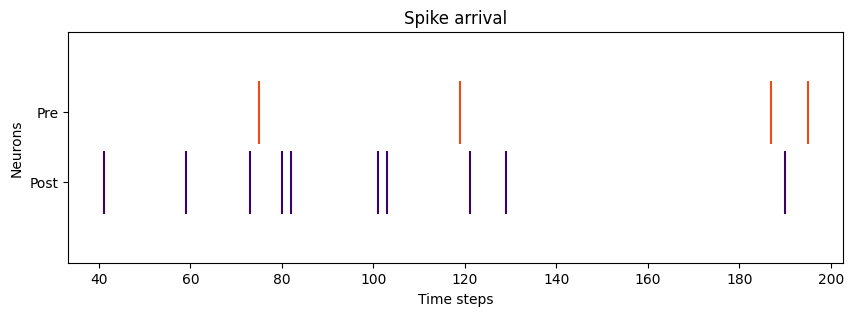

In [10]:
import matplotlib.pyplot as plt

# Plotting pre- and post- spike arrival
def plot_spikes(spikes, legend, colors):
    offsets = list(range(1, len(spikes) + 1))
    
    plt.figure(figsize=(10, 3))
    
    spikes_plot = plt.eventplot(positions=spikes, 
                                lineoffsets=offsets,
                                linelength=0.9,
                                colors=colors)
    
    plt.title("Spike arrival")
    plt.xlabel("Time steps")
    plt.ylabel("Neurons")
    plt.yticks(ticks=offsets, labels=legend)
    
    plt.show()

# Plot spikes
plot_spikes(spikes=[np.where(post_spikes[:, 0])[0], np.where(pre_spikes[:, 0])[0]], 
            legend=['Post', 'Pre'], 
            colors=['#370665', '#f14a16'])

Next, we plot the pre- and post-synaptic spike trace dynamics along with the graded reward spike trace. 

In [ ]:
# Plotting trace dynamics
    
def plot_time_series(time, time_series, ylabel, title):
    plt.figure(figsize=(10, 1))
    
    plt.step(time, time_series)
    
    plt.title(title)
    plt.xlabel("Time steps")
    plt.ylabel(ylabel)
    
    plt.show()
    
# Plotting pre trace dynamics
plot_time_series(time=time, time_series=pre_trace, ylabel="Trace value", title="Pre trace")
# Plotting post trace dynamics
plot_time_series(time=time, time_series=post_trace, ylabel="Trace value", title="Post trace")
# Plotting reward trace dynamics
plot_time_series(time=time, time_series=reward_trace, ylabel="Trace value", title="Reward Trace (Third Factor)")
# Plotting weight dynamics
# TO FIX : plot_time_series(time=time, time_series=weights, ylabel="Weight value", title="Weight dynamics")